In [9]:
import os
import io
import http.client
import typing
import urllib.request
import base64
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Image

In [3]:
"""
GOOGLE_APPLICATION_CREDENTIALS 환경변수: 이 환경변수는 Google Cloud API를 사용하기 위한 인증 정보 파일의 경로를 지정합니다. 
서비스 계정 키 파일(JSON 형식)의 경로를 이 환경변수에 설정하여, 애플리케이션이 Google Cloud 서비스에 접근할 수 있도록 합니다.
"""

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../resources/secret/gemini-api-410603-b4ee00038dea.json"

In [7]:
"""
project_id: Google Cloud 프로젝트 ID는 Google Cloud 리소스와 서비스를 식별하는 데 사용됩니다. 
이 ID는 Google Cloud Console에서 생성한 프로젝트에 할당되며, API 요청 시 이 프로젝트와 관련된 리소스에 접근하는 데 사용됩니다.

location: Google Cloud 서비스의 지리적 위치 또는 지역을 지정합니다. 
이는 데이터 처리 위치나 서비스가 제공되는 지역을 나타내며, 
일반적으로 지연 시간 최소화 및 데이터 주권 준수 등의 요구사항에 따라 선택됩니다.
"""

location = "asia-northeast1"
project_id = "gemini-api-410603"

In [8]:
vertexai.init(project=project_id, location=location)

In [20]:
def load_and_encode_images(prompts):
    encoded_prompts = []
    prompt_details = []
    image_count = 0  # 이미지 개수 카운터
 
    for item in prompts:
        prompt_detail = {"prompt": item}
 
        if item.startswith('http'):  # 이미지 URL인 경우
            response = typing.cast(http.client.HTTPResponse, urllib.request.urlopen(item))
            image_data = response.read()
            pil_image = PILImage.open(io.BytesIO(image_data))
            encoded_image = Image.from_bytes(image_data)
            encoded_prompts.append(encoded_image)
            prompt_detail["type"] = "image"
            prompt_detail["pil_image"] = pil_image
            image_count += 1
        elif item.split('.')[-1].lower() in ['jpg', 'jpeg', 'png']:  # 파일 경로인 경우
            with open(item, "rb") as image_file:
                image_data = image_file.read()
                pil_image = PILImage.open(io.BytesIO(image_data))
                encoded_image = Image.from_bytes(image_data)
                encoded_prompts.append(encoded_image)
                prompt_detail["type"] = "image"
                prompt_detail["pil_image"] = pil_image
                image_count += 1
        else:  # 텍스트인 경우
            encoded_prompts.append(item)
            prompt_detail["type"] = "text"
 
        prompt_details.append(prompt_detail)
 
    return encoded_prompts, prompt_details, image_count
 
def display_response(prompt_details, response_text):
    # 이미지와 텍스트 출력
    for prompt_detail in prompt_details:
        if prompt_detail["type"] == "image":
            plt.imshow(prompt_detail["pil_image"])
            plt.axis('off')
            plt.show()
        # print("Prompt: {} (type: {})".format(prompt_detail['prompt'], prompt_detail['type']))
 
    for candidate in response_text.candidates:
        for part in candidate.content.parts:
            print("Gemini:{}".format(part.text))
 
def chat_gemini(prompts):
    encoded_prompts, pil_images, image_count = load_and_encode_images(prompts)
    print(f"encoded_prompts : {encoded_prompts}")
 
    # 이미지 개수에 따라 모델 선택
    if image_count > 0:
        model_name = "gemini-pro-vision"
    else:
        model_name = "gemini-pro"
 
    # GenerativeModel 객체 생성 및 콘텐츠 생성
    model = GenerativeModel(model_name)
    response = model.generate_content(encoded_prompts)
 
    print(f"Loaded {image_count} images using the '{model_name}' model.")
    display_response(pil_images, response)

def chat_gemini_(prompts):
    # encoded_prompts, pil_images, image_count = load_and_encode_images(prompts)
    # print(f"encoded_prompts : {encoded_prompts}")
 
    # # 이미지 개수에 따라 모델 선택
    # if image_count > 0:
    #     model_name = "gemini-pro-vision"
    # else:
    model_name = "gemini-pro"
 
    # GenerativeModel 객체 생성 및 콘텐츠 생성
    model = GenerativeModel(model_name)
    response = model.generate_content(prompts)
    print(f"response : {response}")
 
    # print(f"Loaded {image_count} images using the '{model_name}' model.")
    # display_response(pil_images, response)

Loaded 1 images using the 'gemini-pro-vision' model.


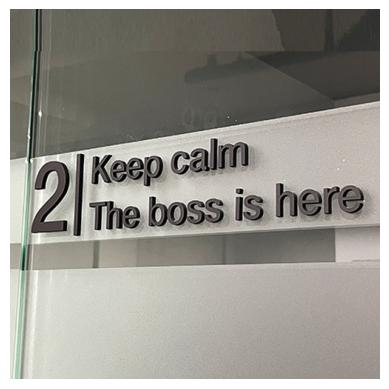

Prompt: test.png (type: image)
Prompt: Read the text in this image. (type: text)
Gemini: 21 Keep calm the boss is here


In [11]:
prompts = ["test.png", "Read the text in this image."]
chat_gemini(prompts)

In [22]:
chat_gemini_("안녕?")

response : candidates {
  content {
    role: "model"
    parts {
      text: "안녕하세요! 저는 훌륭한 대화 상대이자 정보 제공자입니다. 어떤 주제에 대해서든 기꺼이 이야기하고 싶습니다. 오늘은 무엇에 대해 이야기하고 싶으신가요?"
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 3
  candidates_token_count: 54
  total_token_count: 57
}



In [23]:
chat_gemini_("넌 마을 촌장이고 나는 마을의 살인사건을 해결하러 온 탐정이야. 촌장이 탐정에게 사건을 처음 설명해주듯이 말해줘")

response : candidates {
  content {
    role: "model"
  }
  finish_reason: SAFETY
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: MEDIUM
    blocked: true
  }
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 48
  total_token_count: 48
}



In [24]:
chat_gemini_("배고파")

response : candidates {
  content {
    role: "model"
    parts {
      text: "배가 고프시네요. 저도 배고파요. 우리 무엇을 먹을까요? \n식사를 위해 지금 뭐 하고 싶으신가요?\n1. 집에서 요리하기\n2. 배달주문하기\n3. 레스토랑에 가기\n\n집에서 요리하기로 하셨다면 이러한 옵션들을 고려해보세요:\n\n1. 냉장고에 있는 재료로 간단한 식사 만들기\n2. 요리책을 참고해서 새로운 요리를 만들기\n3. 인터넷에 올라와 있는 레시피를 찾아서 만들기\n\n배달주문을 하시겠다면 이러한 옵션을 고려해보세요:\n\n1. 좋아하는 음식을 판매하는 레스토랑에 전화해서 주문하기\n2. 배달앱을 사용해서 음식을 주문하기\n3. 음식 배달 플랫폼을 사용해서 음식을 주문하기\n\n레스토랑에 가시겠다면 이러한 옵션을 고려해보세요:\n\n1. 근처에 있는 레스토랑으로 가서 식사하기\n2. 원하시는 요리를 제공하는 레스토랑으로 가서 식사하기\n3. 재료를 교환하거나 추가해서 맞춤식사를 만들 수 있는 음식점으로 가서 식사하기\n\n다른 걱정 없이 오늘 한 끼를 만족스럽게 드시길 바랍니다! 맛있게 드세요!"
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  

In [25]:
def chat_gemini(prompts):
    model_name = "gemini-pro"
 
    model = GenerativeModel(model_name)
    response = model.generate_content(prompts)
    return response

In [37]:
answer = chat_gemini("배고파")
res = str(answer.candidates[0].finish_reason).split('.')[-1]
print(type(res))
print(res)

<class 'str'>
STOP
